In [1]:
import io
import os
import seaborn as sns
import pathlib
import tensorflow as tf
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from PIL import Image

In [2]:
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
pipeline_config = './myModules/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

print("Modell erfolgreich geladen und gebaut.")

NotFoundError: NewRandomAccessFile failed to Create/Open: ./myModules/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.config : Das System kann die angegebene Datei nicht finden.
; No such file or directory

In [3]:
#Checking for gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.10.1


In [4]:
#Fixing python random seed
random.seed(42)
#fixing numpy random seed
np.random.seed(21)
#fixing tensorflow random seed
tf.compat.v1.random.set_random_seed(42)

## 1. Dataset

In [ ]:
# 1:'Speed limit (30km/h)', 
# 2:'Speed limit (50km/h)',
# 12:'Priority road', 
# 14:'Stop', 
# 17:'No entry',
# 41: 'Ende des Überholverbots',

In [228]:
train_path = './GTSRB/Final_Training/Images'
test_path = './GTSRB/Final_Test/Images'

id_mapping = {1: 1, 2: 2, 12: 3, 14: 4, 17: 5, 41: 6}
unknown_label = 7

### Dataset Setup

In [230]:
def readTrafficSignsTrain(rootpath):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example './GTSRB/Training'
    Returns: DataFrame containing labels, image shapes, ROIs, and image paths'''
    
    # Initialisiere eine leere Liste für die Daten
    data = []

    # loop over all 43 classes
    for c in range(0, 43):
        prefix = f"{rootpath}/{c:05d}/"  # subdirectory for class
        gtFile = open(prefix + f'GT-{c:05d}.csv')  # annotations file
        gtReader = csv.reader(gtFile, delimiter=';')  # csv parser for annotations file
        next(gtReader)  # skip header

        # loop over all images in current annotations file
        for row in gtReader:
            img_path = prefix + row[0]
            img = plt.imread(img_path)  # load image

            label = int(row[7])  # the 8th column is the label
            height = img.shape[0]  # height of the image
            width = img.shape[1]  # width of the image
            #channels = img.shape[2] if len(img.shape) > 2 else 1  # channels of the image (default to 1 if grayscale)
            roi_x1 = int(row[3])  # ROI X1 coordinate
            roi_y1 = int(row[4])  # ROI Y1 coordinate
            roi_x2 = int(row[5])  # ROI X2 coordinate
            roi_y2 = int(row[6])  # ROI Y2 coordinate

            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])

        gtFile.close()

    # Erstelle ein DataFrame aus der Liste
    df = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    return df

In [231]:
def readTrafficSignsTest(rootpath):
    '''Reads the final test data for the German Traffic Sign Recognition Benchmark.
    Arguments: path to the final test data, for example './GTSRB/Final_Test/Images'
    Returns: DataFrame with image data, labels, image shapes, and ROI
    '''
    # Pfad zur CSV-Datei
    csv_file = os.path.join(rootpath, 'GT-final_test_gt.csv')
    
    # Lade die CSV-Datei
    df = pd.read_csv(csv_file, delimiter=';')
    
    # Liste zum Speichern der Daten
    data = []
    
    # Schleife über alle Zeilen der CSV-Datei
    for _, row in df.iterrows():
        img_path = os.path.join(rootpath, row['Filename'])
        img = plt.imread(img_path)  # Lade das Bild
        
        if img is not None:
            label = int(row['ClassId'])
            height, width, channels = img.shape
            roi_x1 = int(row['Roi.X1'])
            roi_y1 = int(row['Roi.Y1'])
            roi_x2 = int(row['Roi.X2'])
            roi_y2 = int(row['Roi.Y2'])
            
            # Füge die Daten als Zeile hinzu
            data.append([width, height, roi_x1, roi_y1, roi_x2, roi_y2, img_path, label])
        else:
            print(f"Bild {img_path} konnte nicht geladen werden.")
    
    # Erstelle ein DataFrame aus der Liste
    df_test = pd.DataFrame(data, columns=['Width', 'Height','Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'Path', 'Label'])
    return df_test

In [232]:
def load_image_into_numpy_array(path):
    image = Image.open(path)
    image = image.resize((280, 280))  # Resize to 280x280
    return np.array(image).astype(np.uint8)

In [233]:
def adjust_class_ids(df, id_map, unknown_label):
    df['AdjustedLabel'] = df['Label'].apply(lambda x: id_map.get(x, unknown_label))
    return df

### 2.1 Dataset export 

In [234]:
df_train_raw = readTrafficSignsTrain(train_path)
df_train = pd.DataFrame()
df_train = df_train_raw.copy()

In [235]:
df_test_raw = readTrafficSignsTest(test_path)
df_test = pd.DataFrame()
df_test = df_test_raw.copy()

In [236]:
df_test_short = adjust_class_ids(df_test, id_mapping, unknown_label)
df_train_short = adjust_class_ids(df_train, id_mapping, unknown_label)

In [237]:
unknown_images_test = df_test_short[df_test_short['AdjustedLabel'] == unknown_label]
unknown_images_train = df_train_short[df_train_short['AdjustedLabel'] == unknown_label]

In [238]:
if len(unknown_images_test) >= 200:
    selected_unknown_images_test = unknown_images_test.sample(n=200, random_state=42)
else:
    print("Nicht genügend Bilder für das Unknown-Label vorhanden.")
    selected_unknown_images_test = unknown_images_test

In [239]:
if len(unknown_images_train) >= 555:
    selected_unknown_images_train = unknown_images_train.sample(n=555, random_state=42)
else:
    print("Nicht genügend Bilder für das Unknown-Label vorhanden.")
    selected_unknown_images_train = unknown_images_train

In [240]:
df_final_train = pd.concat([df_train_short[df_train_short['AdjustedLabel'] != unknown_label], selected_unknown_images_train])
df_final_test = pd.concat([df_test_short[df_test_short['AdjustedLabel'] != unknown_label], selected_unknown_images_test])

In [241]:
df_final_train['Label'] = df_final_train['AdjustedLabel']
df_final_train = df_final_train.drop(columns=['AdjustedLabel'])

df_final_test['Label'] = df_final_test['AdjustedLabel']
df_final_test = df_final_test.drop(columns=['AdjustedLabel'])

In [244]:
df_final_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9255 entries, 210 to 35933
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Width   9255 non-null   int64 
 1   Height  9255 non-null   int64 
 2   Roi.X1  9255 non-null   int64 
 3   Roi.Y1  9255 non-null   int64 
 4   Roi.X2  9255 non-null   int64 
 5   Roi.Y2  9255 non-null   int64 
 6   Path    9255 non-null   object
 7   Label   9255 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 650.7+ KB


### 2.2 Verfify Dataset

In [245]:
short_classes = { 1: 'Geschwindigkeitsbegrenzung (30km/h)', 
                  2: 'Geschwindigkeitsbegrenzung (50km/h)', 
                  3: 'Vorrangstraße', 
                  4: 'Stop', 
                  5: 'Einfahrt verboten', 
                  6: 'Ende des Überholverbots',
                  7: 'Unbekannt'}

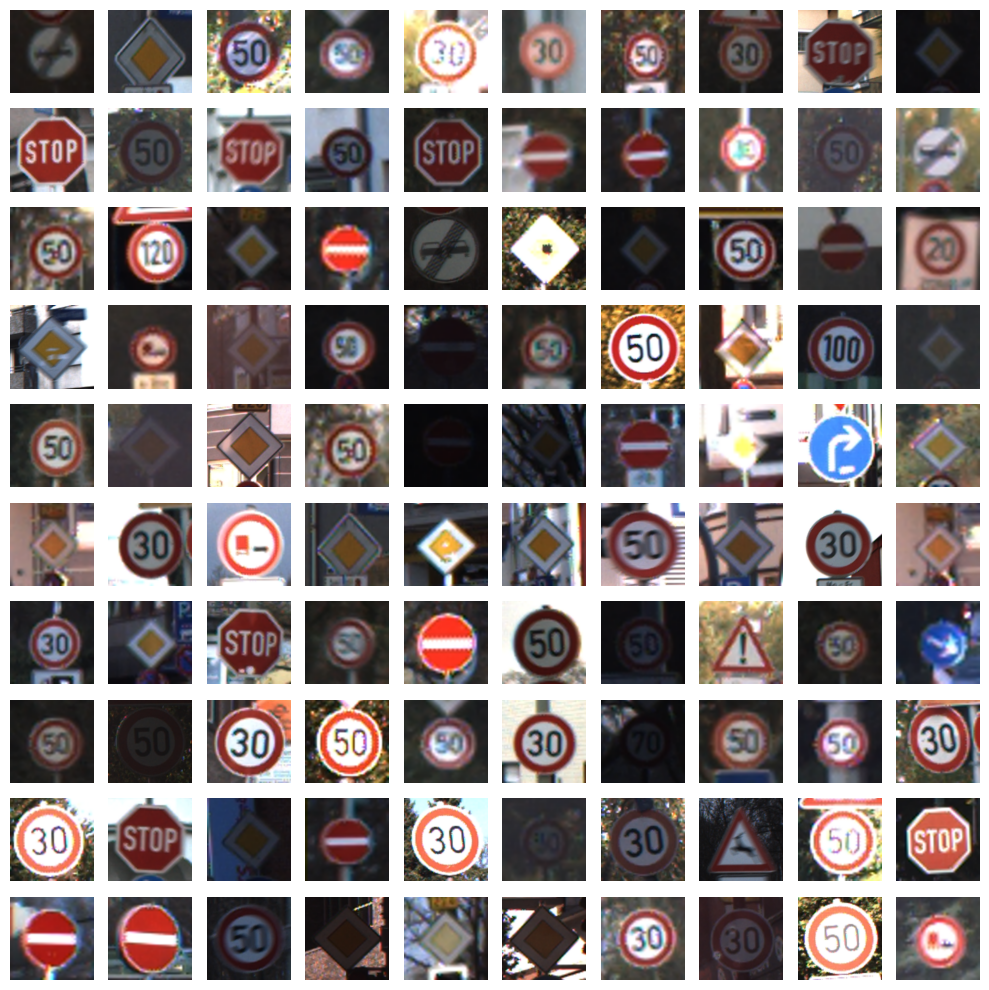

In [246]:
%matplotlib inline
image_paths_to_display = df_final_train['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

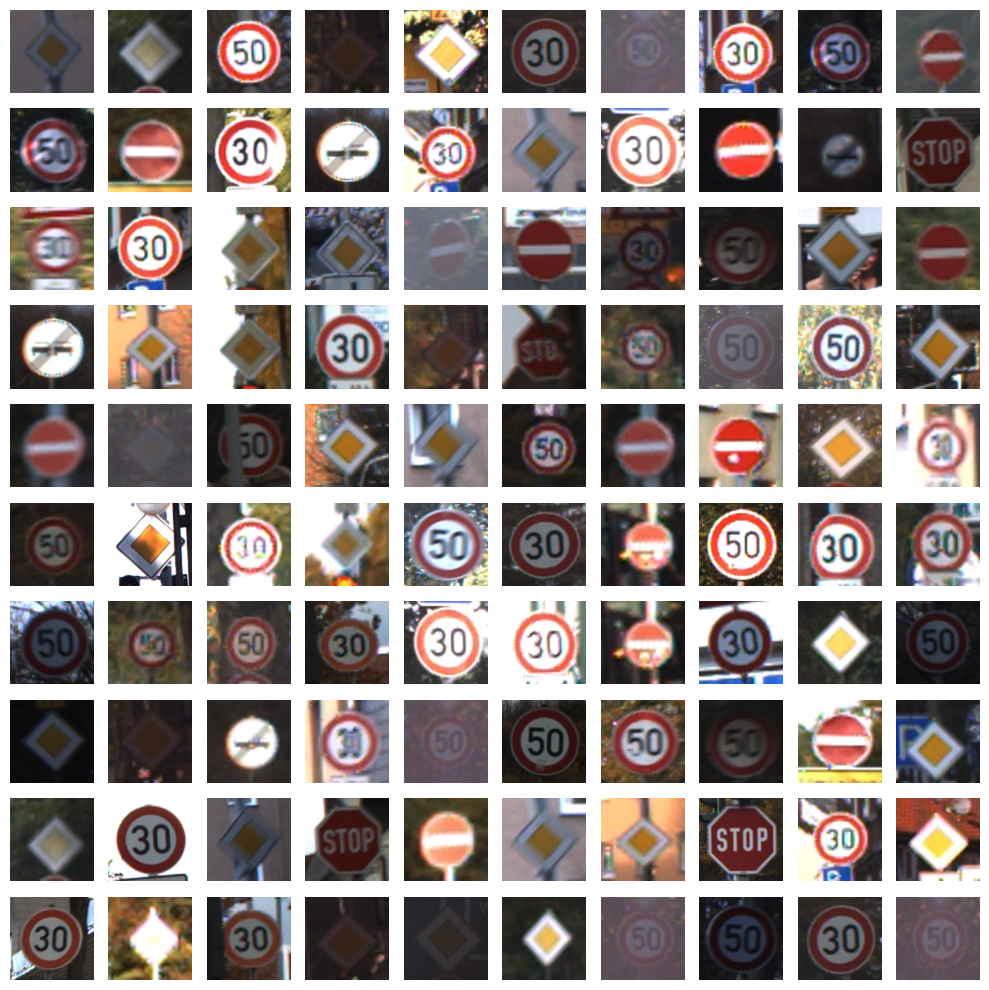

In [35]:
%matplotlib inline
image_paths_to_display = df_test_short['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()

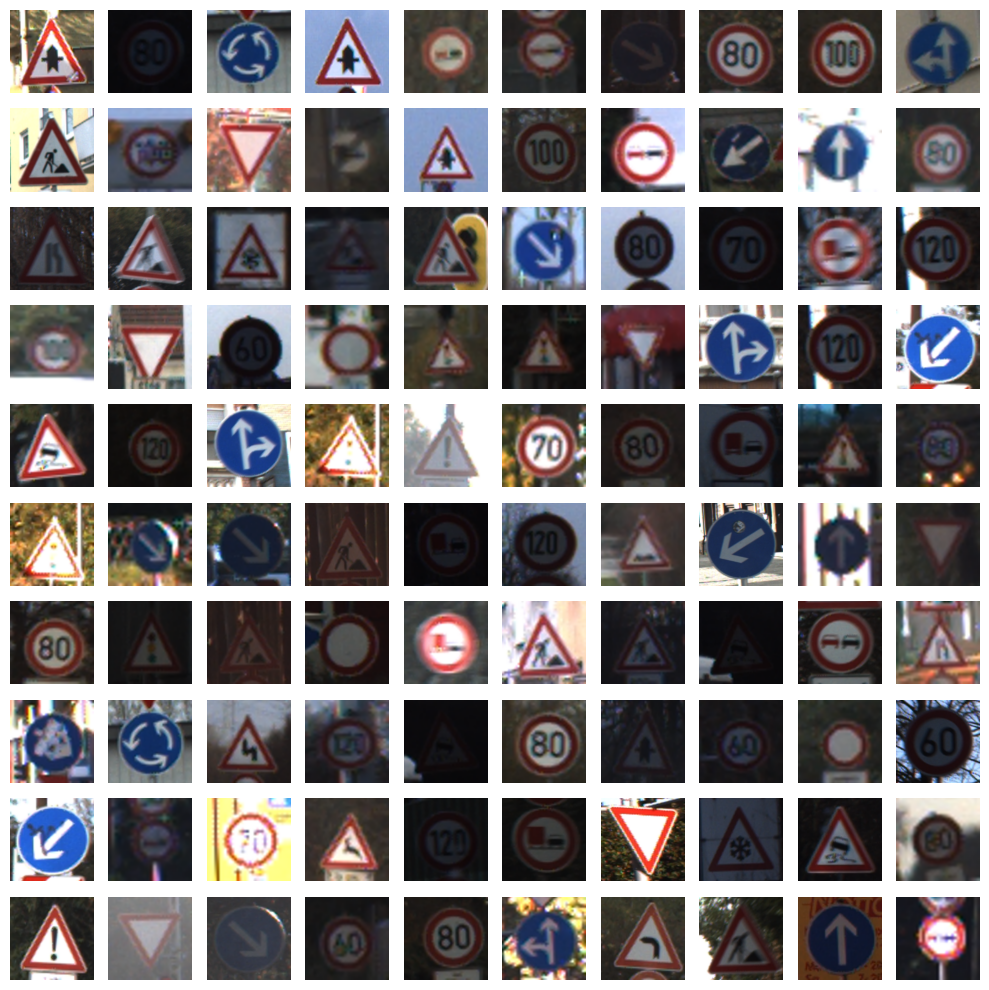

In [247]:
%matplotlib inline
unknown_label_df = df_final_train[df_final_train['Label'] == 7]

# Wähle zufällig 100 Bilder aus
image_paths_to_display = unknown_label_df['Path'].tolist()
image_paths_to_display = random.sample(image_paths_to_display, min(len(image_paths_to_display), 100))

# Plotten der ausgewählten Bilder
plt.figure(figsize=(10, 10))
for i, image_path in enumerate(image_paths_to_display):
    image_np = load_image_into_numpy_array(image_path)  # Funktion, um Bild in ein numpy array zu laden
    plt.subplot(10, 10, i + 1)
    plt.imshow(image_np)
    plt.axis('off')

plt.tight_layout()
plt.show()

C:\Users\Alexej\AppData\Local\Temp\ipykernel_9376\1438436010.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts_named_final.keys()), y=list(label_counts_named_final.values()), palette='viridis')


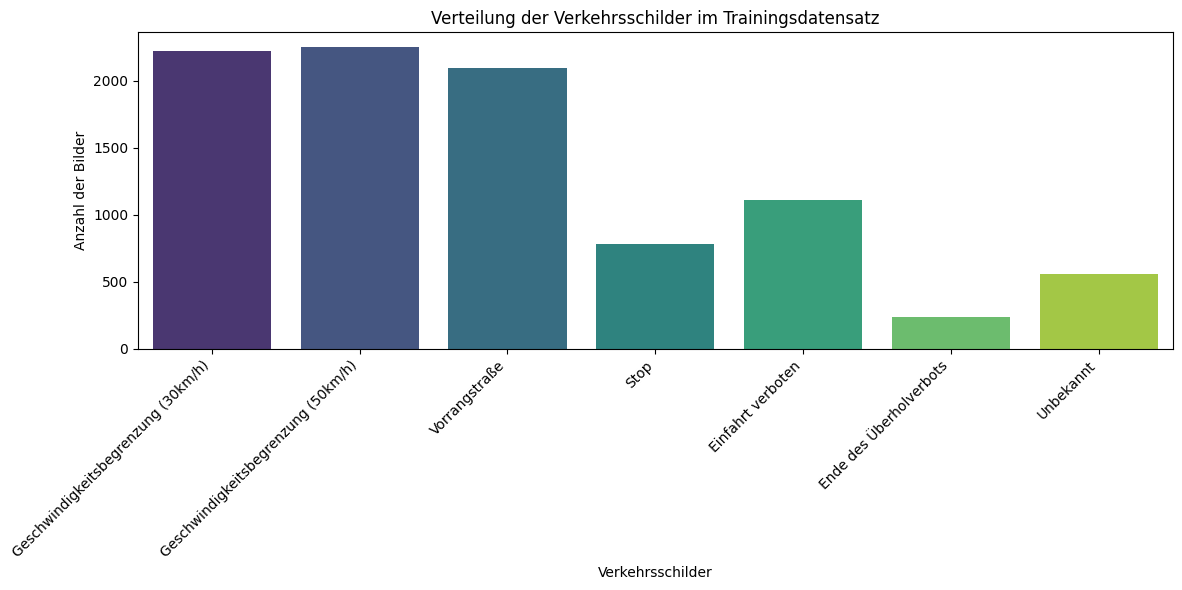

In [248]:
label_counts_final = df_final_train['Label'].value_counts().sort_index()

num_classes = len(label_counts_final)

label_counts_named_final = {short_classes[key]: value for key, value in label_counts_final.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_final.keys()), y=list(label_counts_named_final.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Trainingsdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

In [18]:
label_counts_test = df_test_short['Label'].value_counts().sort_index()
label_counts_train = df_train_short['Label'].value_counts().sort_index()

num_classes = len(label_counts_train)

C:\Users\Alexej\AppData\Local\Temp\ipykernel_7808\3426923357.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts_named_train.keys()), y=list(label_counts_named_train.values()), palette='viridis')


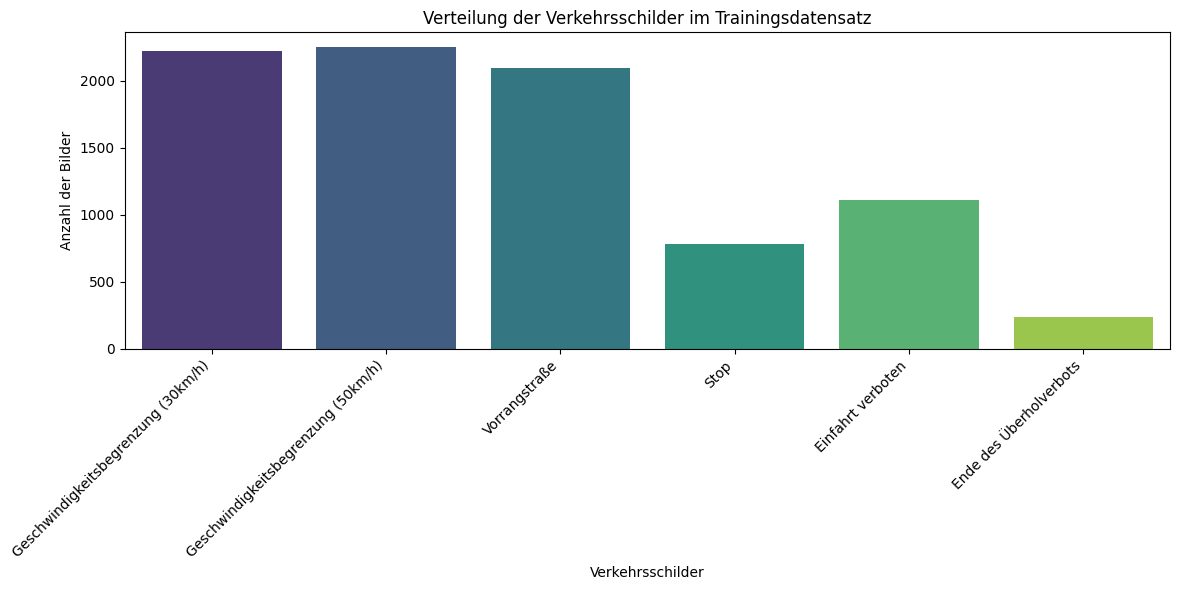

In [21]:
label_counts_named_train = {short_classes[key]: value for key, value in label_counts_train.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_train.keys()), y=list(label_counts_named_train.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Trainingsdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

C:\Users\Alexej\AppData\Local\Temp\ipykernel_7808\813552883.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(label_counts_named_test.keys()), y=list(label_counts_named_test.values()), palette='viridis')


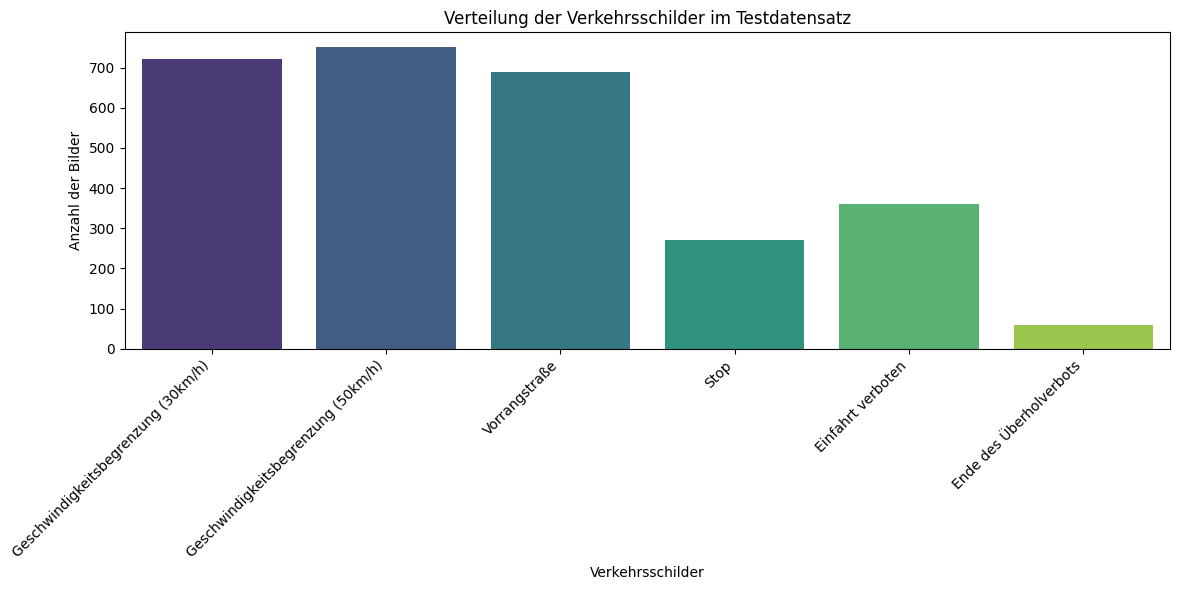

In [20]:
label_counts_named_test = {short_classes[key]: value for key, value in label_counts_test.items()}

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_counts_named_test.keys()), y=list(label_counts_named_test.values()), palette='viridis')
plt.xlabel('Verkehrsschilder')
plt.ylabel('Anzahl der Bilder')
plt.title('Verteilung der Verkehrsschilder im Testdatensatz')
plt.xticks(rotation=45, ha='right')  # Optional: Rotiere die Beschriftungen für bessere Lesbarkeit
plt.tight_layout()
plt.show()

### 2.3 Create Tf-records

In [249]:
def create_tf_example(row):
    img_path = row['Path']
    # Lade das Bild und konvertiere es in ein kompatibles Format (z.B. JPEG)
    image = Image.open(img_path)
    image = image.convert("RGB")
    with io.BytesIO() as output:
        image.save(output, format="JPEG")
        encoded_jpg = output.getvalue()

    width, height = image.size

    filename = row['Path'].encode('utf8')
    image_format = b'jpeg'  # Ändere dies entsprechend des konvertierten Bildformats
    xmins = [row['Roi.X1'] / width]
    xmaxs = [row['Roi.X2'] / width]
    ymins = [row['Roi.Y1'] / height]
    ymaxs = [row['Roi.Y2'] / height]
    classes_text = [str(row['Label']).encode('utf8')]
    classes = [int(row['Label'])]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/source_id': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
        'image/encoded': tf.train.Feature(bytes_list=tf.train.BytesList(value=[encoded_jpg])),
        'image/format': tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_format])),
        'image/object/bbox/xmin': tf.train.Feature(float_list=tf.train.FloatList(value=xmins)),
        'image/object/bbox/xmax': tf.train.Feature(float_list=tf.train.FloatList(value=xmaxs)),
        'image/object/bbox/ymin': tf.train.Feature(float_list=tf.train.FloatList(value=ymins)),
        'image/object/bbox/ymax': tf.train.Feature(float_list=tf.train.FloatList(value=ymaxs)),
        'image/object/class/text': tf.train.Feature(bytes_list=tf.train.BytesList(value=classes_text)),
        'image/object/class/label': tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
    }))
    return tf_example

In [250]:
def create_tf_record(df, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    for _, row in df.iterrows():
        tf_example = create_tf_example(row)
        writer.write(tf_example.SerializeToString())
    writer.close()

In [251]:
create_tf_record(df_final_train, 'train_short_unknown.record')
create_tf_record(df_final_test, 'test_short_unknown.record')

### 2.4 Verify Tensord records

In [252]:
def parse_tf_example(serialized_example):
    feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'image/source_id': tf.io.FixedLenFeature([], tf.string),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/object/bbox/xmin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/xmax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymin': tf.io.FixedLenFeature([], tf.float32),
        'image/object/bbox/ymax': tf.io.FixedLenFeature([], tf.float32),
        'image/object/class/text': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    return tf.io.parse_single_example(serialized_example, feature_description)

In [253]:
def read_tfrecord(record_file):
    raw_dataset = tf.data.TFRecordDataset(record_file)
    parsed_dataset = raw_dataset.map(parse_tf_example)
    return parsed_dataset

In [254]:
def display_image_at_index(parsed_dataset, index):
    for i, tf_example in enumerate(parsed_dataset):
        if i == index:
            height = tf_example['image/height'].numpy()
            width = tf_example['image/width'].numpy()
            encoded_image = tf_example['image/encoded'].numpy()
            xmin = tf_example['image/object/bbox/xmin'].numpy()
            xmax = tf_example['image/object/bbox/xmax'].numpy()
            ymin = tf_example['image/object/bbox/ymin'].numpy()
            ymax = tf_example['image/object/bbox/ymax'].numpy()
            label = tf_example['image/object/class/label'].numpy()

            image = tf.image.decode_jpeg(encoded_image)
            image_np = image.numpy()

            plt.figure(figsize=(4, 4))
            plt.imshow(image_np)
            plt.title(f'Label: {label}')

            # Draw the bounding box
            plt.gca().add_patch(plt.Rectangle((xmin * width, ymin * height), 
                                              (xmax - xmin) * width, (ymax - ymin) * height,
                                              edgecolor='green', facecolor='none', linewidth=2))
            plt.axis('off')
            plt.show()
            break

In [257]:
train_record = read_tfrecord('./train_short_unknown.record')
test_record = read_tfrecord('./test_short_unknown.record')

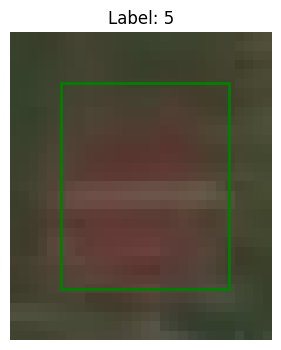

In [298]:
display_image_at_index(test_record, 888)

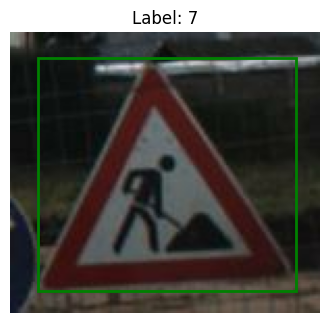

In [303]:
display_image_at_index(train_record, 9006)

## 3. Model

In [262]:
import re

In [263]:
BATCH_SIZE = 2
NUM_CLASSES = 7
NUM_STEPS = 8000
NUM_EVAL_STEPS = 1000
MODEL_NAME = "Faster_RCNN_short_640_101_unknown"
use_bfloat16 = True # Use bfloat16 True for TPU

### 3.1 Faster R-CNN

In [264]:
pipeline_config = "./base_models/faster_rcnn/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/pipeline.config"
fine_tune_checkpoint_path = "./base_models/faster_rcnn/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0"

model_dir = './trained_models/faster_rcnn/{name}'.format(name=MODEL_NAME)
pipeline_config_path = './{name}_config.config'.format(name=MODEL_NAME)

short_labelmap_path = "./myModules/label_map_short_unk.pbtxt"
short_train_record_path = "./train_short_unknown.record"
short_test_record_path = "./test_short_unknown.record"

In [265]:
with open(pipeline_config) as f:
    config = f.read()

with open('{name}_config.config'.format(name=MODEL_NAME), 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(short_labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint_path), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(short_train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(short_test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(NUM_CLASSES), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(BATCH_SIZE), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(NUM_STEPS), config)
  
    # Set use_bfloat16
  config = re.sub('use_bfloat16: (true|false)',
                  'use_bfloat16: {}'.format(str(use_bfloat16).lower()), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [8]:
with open('./Faster_RCNN_short_640_101_config.config', 'r') as file:
    content = file.read()
    print(content)

# Faster R-CNN with Resnet-50 (v1)
# Trained on COCO, initialized from Imagenet classification checkpoint

# Achieves -- mAP on COCO14 minival dataset.

# This config is TPU compatible.

model {
  faster_rcnn {
    num_classes: 6
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 640
        max_dimension: 640
        pad_to_max_dimension: true
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101_keras'
      batch_norm_trainable: true
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    f

## 3.2 Model Training

In [266]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={NUM_STEPS} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={NUM_EVAL_STEPS}

c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

In [ ]:
%load_ext tensorboard

## 4. Inference

In [267]:
import numpy as np
import glob
from IPython.display import display

from six import BytesIO

from PIL import Image, ImageDraw, ImageFont

from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [268]:
IMAGE_WIDTH = 280
IMAGE_HEIGHT = 280

### 4.0 Setup

In [273]:
def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [274]:
def run_inference_for_multiple_images(model, image, min_score_threshold):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key: value[0, :num_detections].numpy() for key, value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)

    # Filter out detections with a score below the threshold
    scores = output_dict['detection_scores']
    high_score_indices = scores >= min_score_threshold

    output_dict['detection_boxes'] = output_dict['detection_boxes'][high_score_indices]
    output_dict['detection_classes'] = output_dict['detection_classes'][high_score_indices]
    output_dict['detection_scores'] = output_dict['detection_scores'][high_score_indices]

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            output_dict['detection_masks'], output_dict['detection_boxes'],
            image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()

    return output_dict

In [275]:
def load_image_into_numpy_array(path, width, height):
    image = Image.open(path)
    # Resize the image to a larger size
    image = image.resize((width, height))  # Resize to 256x256, you can change this as needed
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [276]:
def visualize_boxes_with_color(image, boxes, classes, scores, category_index, box_color, line_thickness):
    for i in range(boxes.shape[0]):
        if scores is None or scores[i] > 0.5:
            class_id = int(classes[i])
            if class_id in category_index.keys():
                class_name = category_index[class_id]['name']
                display_str = str(class_name)
                color = box_color
                vis_util.draw_bounding_box_on_image_array(
                    image,
                    boxes[i][0],
                    boxes[i][1],
                    boxes[i][2],
                    boxes[i][3],
                    color=color,
                    thickness=line_thickness,
                    display_str_list=[display_str],
                    use_normalized_coordinates=True)

In [277]:
def add_legend(image, groundtruth_classes, category_index, iou):
    draw = ImageDraw.Draw(image)
    image_height = image.size[1]
    font_size = max(int(image_height * 0.04), 12)  # Schriftgröße auf 4% der Bildhöhe begrenzt, aber mindestens 12
    font = ImageFont.truetype("arial.ttf", size=font_size)

    y_offset = int(0.9 * image_height)  # Startoffset für die Legende, z.B. 90% der Bildhöhe
    x_offset = int(0.05 * image.size[0])  # Startoffset für die Legende, z.B. 5% der Bildbreite

    # Ground Truth Legende
    for gt_class in groundtruth_classes:
        if gt_class in category_index:
            class_name = category_index[gt_class]['name']
            draw.text((x_offset, y_offset), f"GT: {class_name}\nIoU: {iou:.2f}", fill="yellow", font=font)
            y_offset += int(font_size * 1.5)  # Erhöhe den Offset basierend auf der aktuellen Schriftgröße

In [278]:
def compute_iou(boxA, boxB):
    yA = max(boxA[0], boxB[0])
    xA = max(boxA[1], boxB[1])
    yB = min(boxA[2], boxB[2])
    xB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

In [279]:
def visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index):
    # Visualize ground truth with red color
    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    
    image_pil = Image.fromarray(np.uint8(image_np)).convert("RGB")
    add_legend(image_pil, groundtruth_classes, category_index, iou)
    display(image_pil)

In [280]:
def visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, ax):
    # Visualize ground truth with red color
    visualize_boxes_with_color(
        image_np,
        np.array(groundtruth_boxes),
        np.array(groundtruth_classes),
        np.ones(len(groundtruth_boxes)),
        category_index,
        box_color='red',
        line_thickness=1)
    
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=3)
    
    iou = compute_iou(groundtruth_boxes[0], output_dict['detection_boxes'][0])
    ax.imshow(image_np)
    ax.axis('off')  # Hide the axis

    # Adding legend to the plot
    label_text = category_index[groundtruth_classes[0]]['name']
    ax.set_title(f'{label_text}\nIoU: {iou:.2f}')

In [281]:
def visualize_random_images_for_labels(df, model, category_index, discard_predictions_below_acc, num_images_to_display):
    sorted_labels = sorted(df['Label'].unique())

    num_rows = len(sorted_labels)
    num_cols = num_images_to_display

    _, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols + num_cols * 0.5, num_rows * 2))
    
    if num_rows == 1:
        axes = axes.reshape(1, num_cols)
    else:
        axes = axes.flatten()

    for idx, label in enumerate(sorted_labels):
        label_df = df[df['Label'] == label]
        
        random_indices = random.sample(range(len(label_df)), min(num_images_to_display, len(label_df)))

        for jdx, r_idx in enumerate(random_indices):
            row = label_df.iloc[r_idx]
            image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
            groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
            groundtruth_classes = [row['Label']]
            
            output_dict = run_inference_for_multiple_images(model, image_np, discard_predictions_below_acc)
            
            plot_idx = idx * num_images_to_display + jdx
            
            visualize_predictions_and_groundtruth_plot(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index, axes[plot_idx])
    
    plt.tight_layout()
    plt.show()

In [282]:
def plot_random_predictions_with_groundtruth (model, df, num_images_to_display, category_index):
    
    random_indices = random.sample(range(len(df)), num_images_to_display)

    # Visualisiere zufällige ausgewählte Bilder
    for idx in random_indices:
        row = df.iloc[idx]
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [283]:
def plot_endless_predictions(model, df, category_index):
    
    for _, row in df.iterrows():
        image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
        groundtruth_boxes = [[row['Roi.Y1'] / row['Height'], row['Roi.X1'] / row['Width'], row['Roi.Y2'] / row['Height'], row['Roi.X2'] / row['Width']]]
        groundtruth_classes = [row['Label']]
        
        output_dict = run_inference_for_single_image(model, image_np)
        visualize_predictions_and_groundtruth(image_np, output_dict, groundtruth_boxes, groundtruth_classes, category_index)

In [284]:
def plot_simple_endless_predictions_from_path(model, path, category_index):
    
    for image_path in glob.glob(path):
        image_np = load_image_into_numpy_array(image_path, IMAGE_WIDTH, IMAGE_HEIGHT)
        output_dict = run_inference_for_single_image(model, image_np)
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks_reframed', None),
            use_normalized_coordinates=True,
            line_thickness=1)
        display(Image.fromarray(image_np))

### 4.1 Inference 

In [269]:
output_directory = './inference/faster_rcnn/{name}'.format(name=MODEL_NAME)

In [289]:
!python C:\Users\Alexej\Desktop\GTSRB\models\research\object_detection\exporter_main_v2.py \
    --trained_checkpoint_dir {model_dir} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_config_path}

2024-07-13 18:42:51.312322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-13 18:42:52.409099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6146 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0713 18:42:54.754280  9576 deprecation.py:623] From c:\Users\Alexej\miniconda3\envs\tf-keras\lib\site-packages\tensorflow\python\autograph\impl\api.py:458: cal

In [290]:
category_index = label_map_util.create_category_index_from_labelmap(short_labelmap_path, use_display_name=True)

In [291]:
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'./{output_directory}/saved_model')

### 4.2 Inference Plots 

In [292]:
image_path = './GTSRB/Final_Test/Images/*.ppm'
min_score_threshold = 0.8
number_of_images_to_display = 5

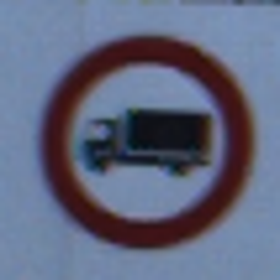

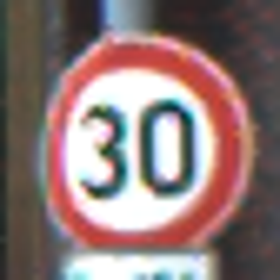

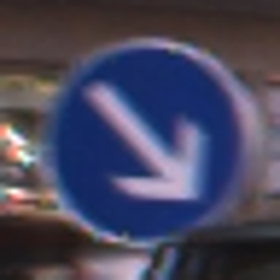

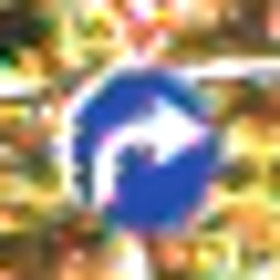

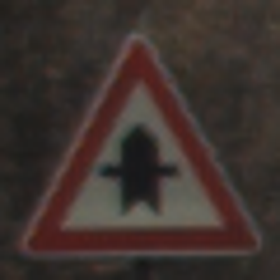

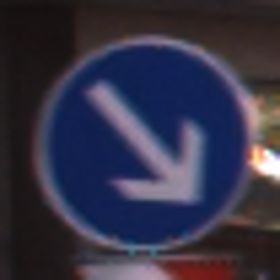

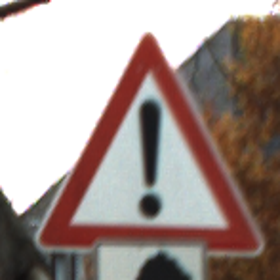

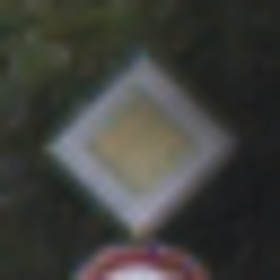

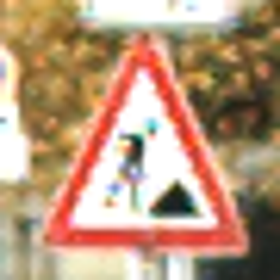

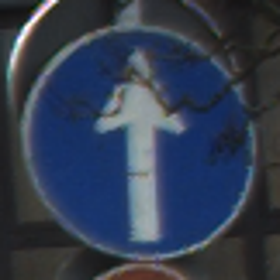

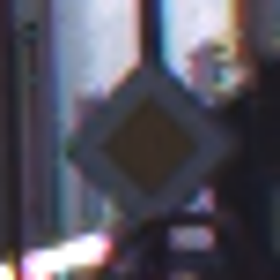

KeyboardInterrupt: 

In [294]:
plot_simple_endless_predictions_from_path(model, image_path, category_index)

In [ ]:
plot_endless_predictions(model, df_test_short, category_index)

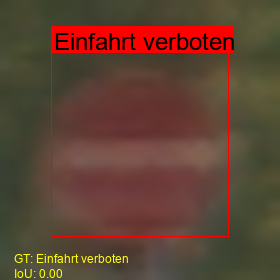

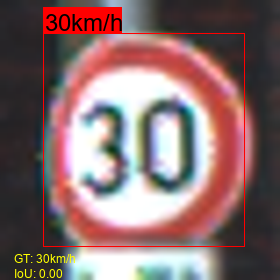

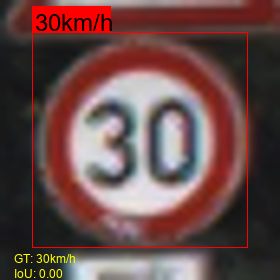

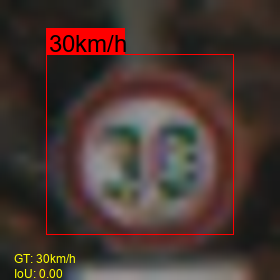

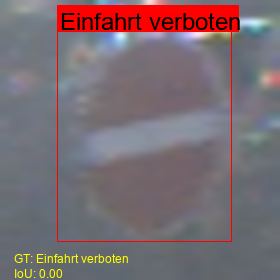

In [293]:
plot_random_predictions_with_groundtruth(model, df_final_test, number_of_images_to_display, category_index)

KeyError: 7

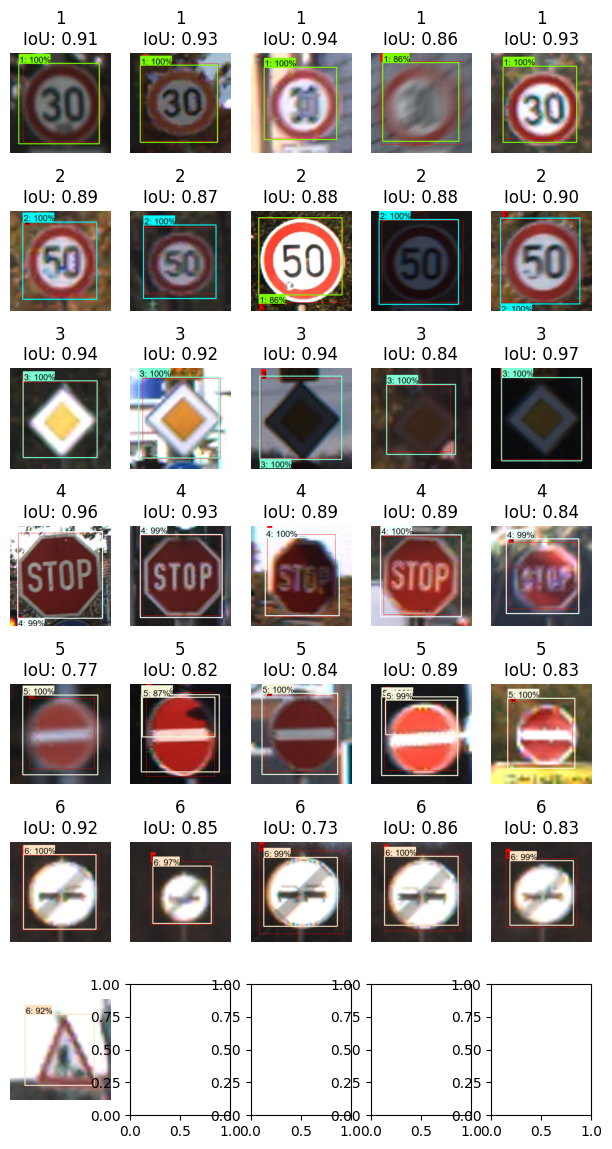

In [286]:
visualize_random_images_for_labels(df_final_test, model, category_index, min_score_threshold, number_of_images_to_display)

## 5. Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [ ]:
all_true_labels = []
all_predicted_labels = []

# Visualisiere zufällig ausgewählte Bilder und sammle Vorhersagen und Ground Truth
for idx, row in df_test_raw.iterrows():
    row = df_test_raw.iloc[idx]
    image_np = load_image_into_numpy_array(row['Path'], IMAGE_WIDTH, IMAGE_HEIGHT)
    groundtruth_classes = [row['Label']]
    
    # Führe die Inferenz für das Bild durch
    output_dict = run_inference_for_single_image(model, image_np)
    
    # Sammle Vorhersagen und Ground Truth
    predicted_class = output_dict['detection_classes'][0]
    all_predicted_labels.append(predicted_class)
    all_true_labels.append(groundtruth_classes[0])

In [ ]:
accuracy = accuracy_score(all_true_labels, all_predicted_labels)
recall = recall_score(all_true_labels, all_predicted_labels, average='weighted')
precision = precision_score(all_true_labels, all_predicted_labels, average='weighted')
f1 = f1_score(all_true_labels, all_predicted_labels, average='weighted')

In [ ]:
# Erstelle die Konfusionsmatrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)

# Definiere die Klassenlabels (optional, wenn bekannt)

# Plotte die Konfusionsmatrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Vorhersage')
plt.ylabel('Wahre Werte')
plt.title('Konfusionsmatrix')
plt.show()

# Drucke den Klassifikationsbericht
print(classification_report(all_true_labels, all_predicted_labels, target_names=class_names))